In [1]:
from IPython.display import Image
import numpy as np
import pandas
import cv2
from datetime import datetime
import keras
import itertools
import warnings
warnings.filterwarnings("ignore")

Зчитуєм дані

In [2]:
test_data = pandas.read_csv('Data_sets/Test_Data150.csv')
test_data.drop(['Unnamed: 0'], axis = 1, inplace = True)
print(test_data.shape)

(150, 2)


In [3]:
test_data.head()

,ImageName,Labels
0,SynthImageDataset/3000/7/182_slinking_71711.jpg,SLINKING
1,SynthImageDataset/3000/7/181_REMODELERS_64541.jpg,REMODELERS
2,SynthImageDataset/3000/7/180_Chronographs_1353...,CHRONOGRAPHS
3,SynthImageDataset/3000/7/179_Impeaching_38222.jpg,IMPEACHING
4,SynthImageDataset/3000/7/177_Loots_45256.jpg,LOOTS


Допоміжні функції

In [4]:
#Letters present in the Label Text
letters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [5]:
def words_from_labels(labels):
    """
    converts the list of encoded integer labels to word strings like eg. [12,10,29] returns CAT 
    """
    txt=[]
    for ele in labels:
        if ele == len(letters): # CTC blank space
            txt.append("")
        else:
            txt.append(letters[ele])
    return "".join(txt)

In [6]:
def decode_label(out):
    """
    Takes the predicted ouput matrix from the Model and returns the output text for the image
    """
    # out : (1, 48, 37)
    out_best = list(np.argmax(out[0,2:], axis = 1))

    out_best = [k for k, g in itertools.groupby(out_best)]  # remove overlap value

    outstr=words_from_labels(out_best)
    return outstr

In [7]:
#image height
img_h = 32
#image width
img_w = 170
#image Channels
img_c = 1
# classes for softmax with number of letters +1 for blank space in ctc
num_classes = len(letters) + 1
batch_size = 64
max_length = 15 # considering max length of ground truths labels to be 15

Функція для передбачення тексту на 1 картинці

In [1]:
def single_image_Prediction(model, img_path):
    start = datetime.now()
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (170,32))
    img = img_resized[:,:,1]
    img = img.T 
    img = np.expand_dims(img,axis=-1)
    img = np.expand_dims(img, axis=0)
    img = img/255
    model_output = model.predict(img)
    predicted_output = decode_label(model_output)
    print("Predicted Text in the Image: ", predicted_output)
    print("Time Taken for Processing: ", datetime.now()-start)    

KeyboardInterrupt: 

Функція для передбачення тексту на наборі картинок і обчислення точності

In [9]:
def multiple_image_Prediction(model, img_names, labels, total):
    start = datetime.now()
    accuracy = 0
    letter_acc = 0
    letter_cnt = 0
    count = 0
    for i in range(len(labels)):
        img = cv2.imread(img_names[i])
        img_resized = cv2.resize(img,(170,32))
        img = img_resized[:,:,1]
        img = img.T
        img = np.expand_dims(img, axis=-1)
        img = np.expand_dims(img, axis=0)
        img = img/255
        model_output = model.predict(img)
        predicted_output = decode_label(model_output)
        actual_output = labels[i]
        count += 1
        for j in range(min(len(predicted_output), len(actual_output))):
            if predicted_output[j] == actual_output[j]:
                letter_acc += 1
        letter_cnt += max(len(predicted_output), len(actual_output))
        if actual_output==predicted_output:
            accuracy += 1
        print("-"*80)
        print("Actual Text: ", actual_output,"   Predicted Text: ", predicted_output)
    print("="*80)
    print("Model Output Accuracy: ", (accuracy/total)*100, " %")
    print("Model Output Letter Accuracy: ", (letter_acc/letter_cnt)*100, " %")
    print("Time Taken for Processing: ", datetime.now()-start)

Зчитуєм модель

In [10]:
file = open('Models/modelBiggest.json',mode='r')
 
# read all lines at once
model_txt = file.read()

model = keras.models.model_from_json(model_txt)

In [16]:
model.load_weights('Models/BiggestModel.01-1.19.h5')

Перевіряєм на поодиноких картинках

In [12]:
test_image_1='Test_Data/3_Chronographs.jpg'
Image(test_image_1)

In [13]:
single_image_Prediction(model,test_image_1)

1/1 [==============================] - 2s 2s/step
Predicted Text in the Image:  CHNONOGRAPHS
Time Taken for Processing:  0:00:01.863558


Перевірка моделі на картинці з фотоапарата

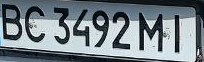

In [ ]:
test_image_2='Test.jpg'
Image(test_image_2)

In [19]:
single_image_Prediction(model,test_image_2)

1/1 [==============================] - 0s 53ms/step
Predicted Text in the Image:  BESSIZMI
Time Taken for Processing:  0:00:00.101093


In [14]:
test_image_3='Test_Data/48_SCHOOLBOY.jpg'
Image(test_image_3)

In [15]:
single_image_Prediction(model,test_image_3)

1/1 [==============================] - 0s 70ms/step
Predicted Text in the Image:  SCHOOLBOY
Time Taken for Processing:  0:00:00.114104


Перевірка на багатьох картинках

In [14]:
test_img_paths=test_data['ImageName'].values
test_img_labels=test_data['Labels'].values
total = 150

In [18]:
multiple_image_Prediction(model, test_img_paths, test_img_labels, total)

1/1 [==============================] - 0s 41ms/step
--------------------------------------------------------------------------------
Actual Text:  SLINKING    Predicted Text:  SLINKING
1/1 [==============================] - 0s 39ms/step
--------------------------------------------------------------------------------
Actual Text:  REMODELERS    Predicted Text:  REMODELERS
1/1 [==============================] - 0s 41ms/step
--------------------------------------------------------------------------------
Actual Text:  CHRONOGRAPHS    Predicted Text:  CHRONOGRAPHS
1/1 [==============================] - 0s 52ms/step
--------------------------------------------------------------------------------
Actual Text:  IMPEACHING    Predicted Text:  IMPEACHING
1/1 [==============================] - 0s 40ms/step
--------------------------------------------------------------------------------
Actual Text:  LOOTS    Predicted Text:  LOOTS
1/1 [==============================] - 0s 41ms/step
-------------